### Loading the libararies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

/Users/adityasingh/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Reading the cleaned data

In [2]:
data = pd.read_csv("../data/clean_tweet.csv", index_col=0)
data.head()

text  target
0  awww that bummer you shoulda got david carr of...       0
1  is upset that he can not update his facebook b...       0
2  dived many times for the ball managed to save ...       0
3     my whole body feels itchy and like its on fire       0
4  no it not behaving at all mad why am here beca...       0

### WordCloud

A word cloud is a form of visual representation. It is a grouping of words that are displayed in various sizes: the larger and bolder the term, the more frequently it appears in a document and the more important it is.

#### Negative wordcloud

In [6]:
neg_tweets = data[data.target==0]
neg_tweets_array = []
for t in neg_tweets.text:
    neg_tweets_array.append(t)

neg_tweets_string = " ".join(neg_tweets_array)

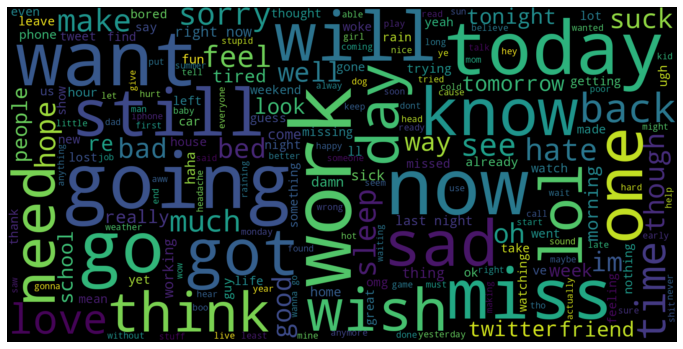

In [8]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_tweets_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Positive wordcloud

In [11]:
pos_tweets = data[data.target==4]
pos_tweets_array = []
for t in pos_tweets.text:
    pos_tweets_array.append(t)

pos_tweets_string = " ".join(pos_tweets_array)

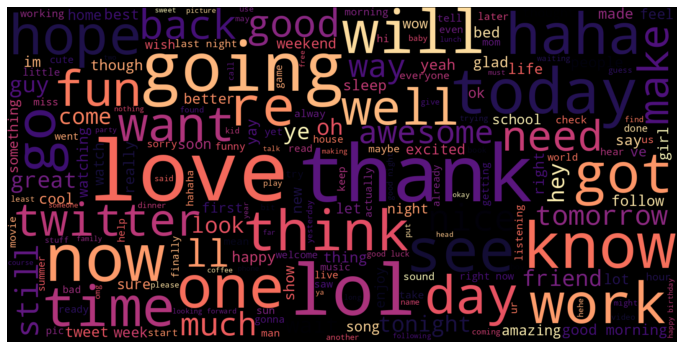

In [12]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, colormap="magma").generate(pos_tweets_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Count vectorizer

Machines cannot understand characters and words. So when dealing with text data we need to represent it in numbers to be understood by the machine. Countvectorizer is a method to convert text to numerical data.

CountVectorizer makes the matrix where every row correspond to each sample of text and corresponding column is 0 or 1 based on whether the word is present in the text or not.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
cvec = CountVectorizer()
cvec.fit(data.text)

CountVectorizer()

In [5]:
len(cvec.get_feature_names_out())

264939

This code snippet performs text analysis using a CountVectorizer (`cvec`) on a dataset (`data`) with binary classification labels (0 and 1). It creates document-term matrices for the negative (target==0) and positive (target==1) classes, calculates term frequencies for each class, and organizes the results into a DataFrame (`term_freq_df`). This DataFrame presents a tabular view where rows represent terms (features), and columns display the total term frequencies for the negative and positive classes. The resulting DataFrame is then displayed with the `head()` function, offering a glimpse into the distribution of term frequencies across the two classes. This process aids in understanding the importance of terms in distinguishing between the two classes in the given text data.

In [7]:
neg_doc_matrix = cvec.transform(data[data.target==0].text)
pos_doc_matrix = cvec.transform(data[data.target==1].text)

neg_tf = np.sum(neg_doc_matrix, axis=0)
pos_tf = np.sum(pos_doc_matrix, axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos], columns=cvec.get_feature_names_out()).transpose()
term_freq_df.head()

0   1
aa      160  92
aaa      93  54
aaaa     45  29
aaaaa    26  12
aaaaaa   16  12

In [8]:
term_freq_df.columns = ['neg', 'pos']
term_freq_df['total'] = term_freq_df.neg + term_freq_df.pos
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

neg     pos   total
to   313162  252567  565729
the  257836  265998  523834
my   190775  125955  316730
it   157448  147786  305234
and  153958  149642  303600
you  103844  198245  302089
not  194724   86861  281585
is   133432  111191  244623
in   115542  101160  216702
for   98999  117369  216368

In [10]:
term_freq_df.to_csv("../data/term_freq_df.csv")

### Zipf's law

Zipf's Law, named after linguist George Zipf, observes that in a given corpus of natural language, the frequency of a word is inversely proportional to its rank. In simpler terms, a few words occur very frequently, while the majority are rare. This phenomenon is often described as a power-law distribution, highlighting the skewed nature of word frequency in language. Zipf's Law has implications in various fields, including linguistics, economics, and information retrieval, providing insights into the uneven distribution of importance or usage among elements in a system.

This code generates a bar plot comparing the actual frequency distribution of the top 500 tokens in a set of tweets with the expected frequency distribution according to Zipf's Law. The variable y_pos represents the positions of the bars along the y-axis. The actual frequencies are obtained from the 'total' column of the DataFrame term_freq_df, sorted in descending order. The red dashed line represents the expected Zipf distribution, where the frequency of a token is inversely proportional to its rank. The plot provides a visual comparison between the observed token frequencies and the theoretical Zipf distribution, helping to assess how well the language in the tweets aligns with Zipf's Law.

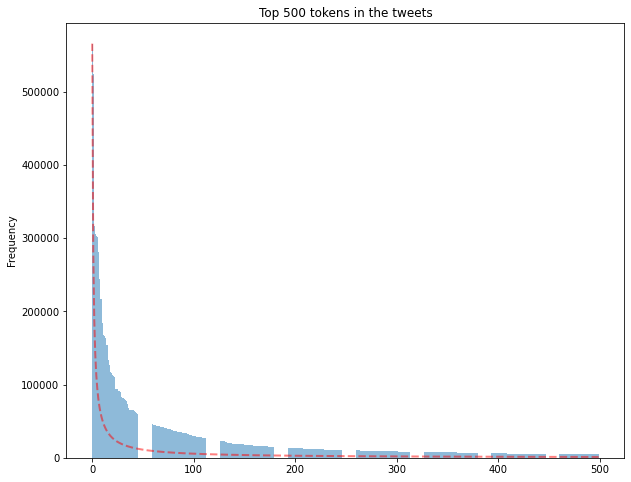

In [25]:
y_pos = np.arange(500)
plt.figure(figsize = (10,8))
s=1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--', linewidth=2, alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 tokens in the tweets')
plt.show()

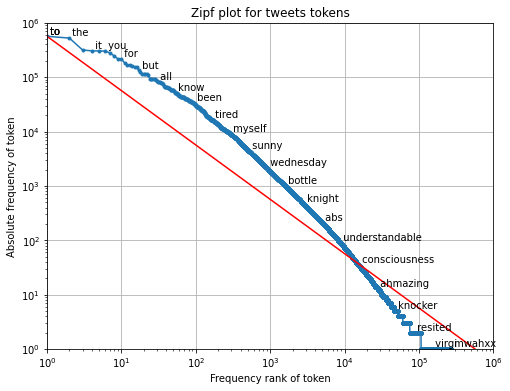

In [26]:
from pylab import *
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for tweets tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")


At least, we proved that even the tweet tokens follow “near-Zipfian” distribution, but this introduced me to a curiosity about the deviation from the Zipf’s Law. Even though the law itself states that the actual observation follows “near-Zipfian” rather than strictly bound to the law, but is the area we observed above the expected line in higher ranks just by chance? Or does it mean that tweets use frequent words more heavily than other text corpora? Is there statistically significant difference compared to other text corpora?


```
Thoughts from https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-3-zipfs-law-data-visualisation-fc9eadda71e7
```

In [28]:
cvec_10000 = CountVectorizer(max_features=10000, stop_words='english')
cvec_10000.fit(data.text)

CountVectorizer(max_features=10000, stop_words='english')

In [31]:
neg_doc_matrix = cvec_10000.transform(data[data.target==0].text)
pos_doc_matrix = cvec_10000.transform(data[data.target==4].text)

neg_tf = np.sum(neg_doc_matrix, axis=0)
pos_tf = np.sum(pos_doc_matrix, axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos], columns=cvec_10000.get_feature_names_out()).transpose()
term_freq_df.head()

0   1
aa      160  92
aaa      93  54
aaaa     45  29
aaaah    76  61
aaaand   33  37

In [32]:
term_freq_df.columns = ['neg', 'pos']
term_freq_df['total'] = term_freq_df.neg + term_freq_df.pos
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

neg    pos   total
just   64004  62944  126948
good   29209  62118   91327
day    41374  48186   89560
like   41050  37520   78570
today  38116  30100   68216
work   45420  19529   64949
love   16990  47694   64684
going  33689  30939   64628
got    33408  28037   61445
lol    23123  36118   59241

Text(0.5, 1.0, 'Top 50 tokens in negative tweets')

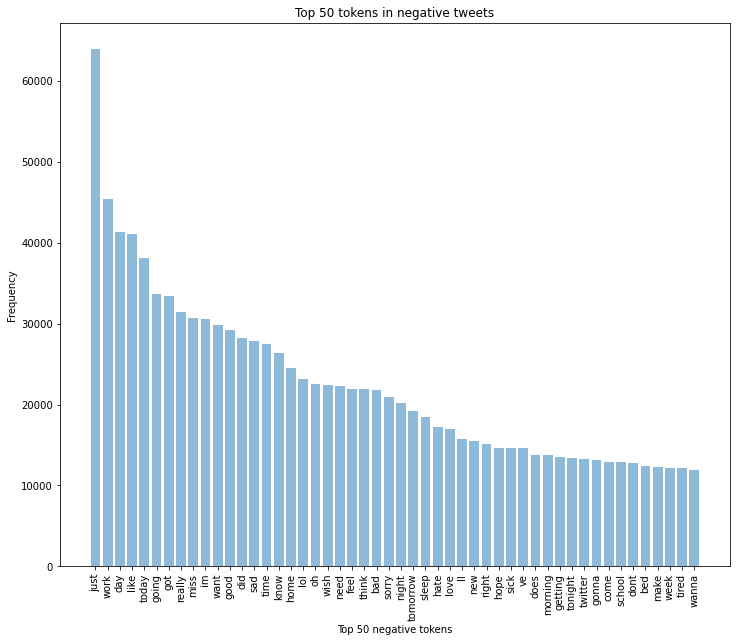

In [36]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df.sort_values(by='neg', ascending=False)['neg'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='neg', ascending=False)['neg'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 tokens in negative tweets')

Text(0.5, 1.0, 'Top 50 tokens in positive tweets')

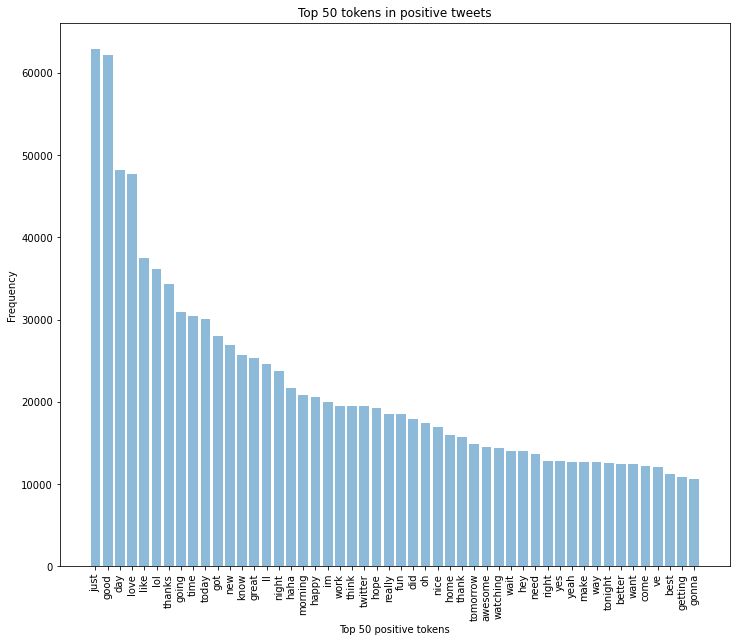

In [37]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df.sort_values(by='pos', ascending=False)['pos'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='pos', ascending=False)['pos'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 positive tokens')
plt.title('Top 50 tokens in positive tweets')

Text(0.5, 1.0, 'Negative Frequency vs Positive Frequency')

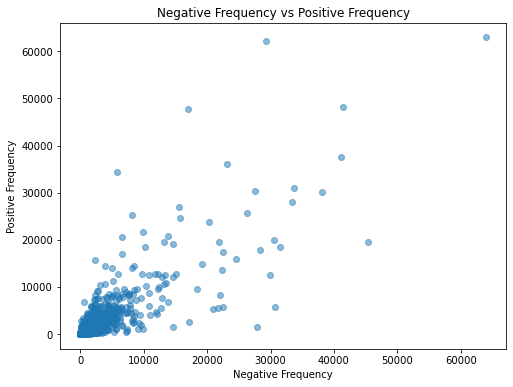

In [38]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg", y="pos",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

### Below are the statistical methods applied on the data

In [40]:
term_freq_df['pos_rate'] = term_freq_df['pos'] * 1./term_freq_df['total']
term_freq_df.sort_values(by='pos_rate', ascending=False).iloc[:10]

neg  pos  total  pos_rate
emailunlimited    0  100    100  1.000000
dividends         0   83     83  1.000000
mileymonday       0  161    161  1.000000
shareholder       1   80     81  0.987654
fuzzball          2   99    101  0.980198
recommends        3  109    112  0.973214
delongeday        6  162    168  0.964286
atcha             3   80     83  0.963855
timestamp         3   68     71  0.957746
shaundiviney      4   89     93  0.956989

In [41]:
term_freq_df['pos_freq_pct'] = term_freq_df['pos'] * 1./term_freq_df['pos'].sum()
term_freq_df.sort_values(by='pos_freq_pct', ascending=False).iloc[:10]

neg    pos   total  pos_rate  pos_freq_pct
just    64004  62944  126948  0.495825      0.014396
good    29209  62118   91327  0.680171      0.014207
day     41374  48186   89560  0.538030      0.011021
love    16990  47694   64684  0.737338      0.010908
like    41050  37520   78570  0.477536      0.008581
lol     23123  36118   59241  0.609679      0.008261
thanks   5768  34375   40143  0.856314      0.007862
going   33689  30939   64628  0.478724      0.007076
time    27526  30432   57958  0.525070      0.006960
today   38116  30100   68216  0.441245      0.006884

In [42]:
from scipy.stats import hmean
term_freq_df['pos_hmean'] = term_freq_df.apply(lambda x: (hmean([x['pos_rate'], x['pos_freq_pct']])                                                               if x['pos_rate'] > 0 and x['pos_freq_pct'] > 0 else 0), axis=1)
                                                       
term_freq_df.sort_values(by='pos_hmean', ascending=False).iloc[:10]

neg    pos   total  pos_rate  pos_freq_pct  pos_hmean
just    64004  62944  126948  0.495825      0.014396   0.027980
good    29209  62118   91327  0.680171      0.014207   0.027833
day     41374  48186   89560  0.538030      0.011021   0.021599
love    16990  47694   64684  0.737338      0.010908   0.021498
like    41050  37520   78570  0.477536      0.008581   0.016860
lol     23123  36118   59241  0.609679      0.008261   0.016300
thanks   5768  34375   40143  0.856314      0.007862   0.015581
going   33689  30939   64628  0.478724      0.007076   0.013946
time    27526  30432   57958  0.525070      0.006960   0.013738
today   38116  30100   68216  0.441245      0.006884   0.013557

In [44]:
from scipy.stats import norm
def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())
term_freq_df['pos_rate_normcdf'] = normcdf(term_freq_df['pos_rate'])
term_freq_df['pos_freq_pct_normcdf'] = normcdf(term_freq_df['pos_freq_pct'])
term_freq_df['pos_normcdf_hmean'] = hmean([term_freq_df['pos_rate_normcdf'], term_freq_df['pos_freq_pct_normcdf']])
term_freq_df.sort_values(by='pos_normcdf_hmean',ascending=False).iloc[:10]

neg    pos  total  pos_rate  pos_freq_pct  pos_hmean  \
welcome   620   6702   7322  0.915324      0.001533   0.003061   
thank    2282  15736  18018  0.873349      0.003599   0.007168   
thanks   5768  34375  40143  0.856314      0.007862   0.015581   
awesome  3821  14469  18290  0.791088      0.003309   0.006591   
glad     2273   8255  10528  0.784100      0.001888   0.003767   
follow   2552   9154  11706  0.781992      0.002094   0.004176   
enjoy    1642   5876   7518  0.781591      0.001344   0.002683   
sweet    1610   5646   7256  0.778115      0.001291   0.002578   
yay      3165  10501  13666  0.768403      0.002402   0.004788   
hello    1122   4524   5646  0.801275      0.001035   0.002067   

         pos_rate_normcdf  pos_freq_pct_normcdf  pos_normcdf_hmean  
welcome          0.995623              0.999369           0.997493  
thank            0.990791              1.000000           0.995374  
thanks           0.987770              1.000000           0.993847  
awesome          0.967038              1.000000           0.983243  
glad             0.963666              0.999971           0.981483  
follow           0.962596              0.999996           0.980940  
enjoy            0.962389              0.997441           0.979602  
sweet            0.960559              0.996331           0.978118  
yay              0.955061              1.000000           0.977014  
hello            0.971487              0.982293           0.976860

In [46]:
term_freq_df['neg_rate'] = term_freq_df['neg'] * 1./term_freq_df['total']
term_freq_df['neg_freq_pct'] = term_freq_df['neg'] * 1./term_freq_df['neg'].sum()
term_freq_df['neg_hmean'] = term_freq_df.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_pct']])                                                                if x['neg_rate'] > 0 and x['neg_freq_pct'] > 0                                                                else 0), axis=1)
                                                       
term_freq_df['neg_rate_normcdf'] = normcdf(term_freq_df['neg_rate'])
term_freq_df['neg_freq_pct_normcdf'] = normcdf(term_freq_df['neg_freq_pct'])
term_freq_df['neg_normcdf_hmean'] = hmean([term_freq_df['neg_rate_normcdf'], term_freq_df['neg_freq_pct_normcdf']])
term_freq_df.sort_values(by='neg_normcdf_hmean', ascending=False).iloc[:10]

neg   pos  total  pos_rate  pos_freq_pct  pos_hmean  \
sad       27911  1510  29421  0.051324      0.000345   0.000686   
hurts      7204   456   7660  0.059530      0.000104   0.000208   
sick      14617  1419  16036  0.088488      0.000325   0.000647   
sucks      9902   982  10884  0.090224      0.000225   0.000448   
poor       7333   719   8052  0.089295      0.000164   0.000328   
ugh        9056   998  10054  0.099264      0.000228   0.000455   
missing    7282   991   8273  0.119787      0.000227   0.000452   
headache   5317   421   5738  0.073371      0.000096   0.000192   
hate      17207  2614  19821  0.131880      0.000598   0.001190   
miss      30713  5676  36389  0.155981      0.001298   0.002575   

          pos_rate_normcdf  pos_freq_pct_normcdf  pos_normcdf_hmean  neg_rate  \
sad               0.002393              0.709591           0.004771  0.948676   
hurts             0.002808              0.503854           0.005585  0.940470   
sick              0.004842              0.693343           0.009616  0.911512   
sucks             0.004997              0.610419           0.009914  0.909776   
poor              0.004913              0.557659           0.009741  0.910705   
ugh               0.005883              0.613574           0.011655  0.900736   
missing           0.008429              0.612194           0.016629  0.880213   
headache          0.003657              0.496667           0.007261  0.926629   
hate              0.010345              0.868740           0.020446  0.868120   
miss              0.015317              0.996497           0.030171  0.844019   

          neg_freq_pct  neg_hmean  neg_rate_normcdf  neg_freq_pct_normcdf  \
sad           0.006096   0.012114          0.997607              1.000000   
hurts         0.001573   0.003141          0.997192              0.999742   
sick          0.003192   0.006362          0.995158              1.000000   
sucks         0.002163   0.004315          0.995003              0.999999   
poor          0.001602   0.003197          0.995087              0.999799   
ugh           0.001978   0.003947          0.994117              0.999995   
missing       0.001590   0.003175          0.991571              0.999778   
headache      0.001161   0.002320          0.996343              0.993811   
hate          0.003758   0.007484          0.989655              1.000000   
miss          0.006708   0.013310          0.984683              1.000000   

          neg_normcdf_hmean  
sad                0.998802  
hurts              0.998465  
sick               0.997573  
sucks              0.997495  
poor               0.997437  
ugh                0.997047  
missing            0.995658  
headache           0.995075  
hate               0.994801  
miss               0.992282

Text(0.5, 1.0, 'neg_hmean vs pos_hmean')

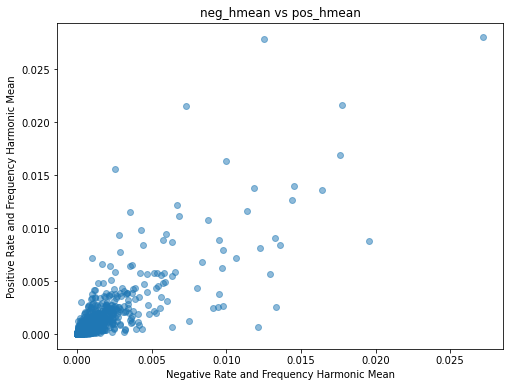

In [47]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_hmean", y="pos_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df)
plt.ylabel('Positive Rate and Frequency Harmonic Mean')
plt.xlabel('Negative Rate and Frequency Harmonic Mean')
plt.title('neg_hmean vs pos_hmean')

Text(0.5, 1.0, 'neg_normcdf_hmean vs pos_normcdf_hmean')

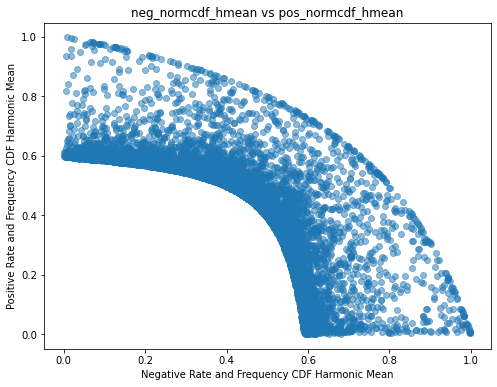

In [48]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_normcdf_hmean", y="pos_normcdf_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df)
plt.ylabel('Positive Rate and Frequency CDF Harmonic Mean')
plt.xlabel('Negative Rate and Frequency CDF Harmonic Mean')
plt.title('neg_normcdf_hmean vs pos_normcdf_hmean')

In [51]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper
from bokeh.models import HoverTool
output_notebook()
color_mapper = LinearColorMapper(palette='Inferno256', low=min(term_freq_df.pos_normcdf_hmean), high=max(term_freq_df.pos_normcdf_hmean))
p = figure(x_axis_label='neg_normcdf_hmean', y_axis_label='pos_normcdf_hmean')
p.circle('neg_normcdf_hmean','pos_normcdf_hmean',size=5,alpha=0.3,source=term_freq_df,color={'field': 'pos_normcdf_hmean', 'transform': color_mapper})
hover = HoverTool(tooltips=[('token','@index')])
p.add_tools(hover)
show(p)

Loading BokehJS ...